# House Prices Prediction

### Índice
- Panorama
- Pre processamento
    - Imputações
    - Label Encoding
- Análise de variáveis categóricas
- Análise de variáveis numéricas
- Detecção de outliers

## Import the library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency, chi2, kruskal
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_decision_forests as tfdf


## Load the dataset


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Panorama: Um olhar antes das imputações

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Gráficos de distribuição de variáveis numéricas


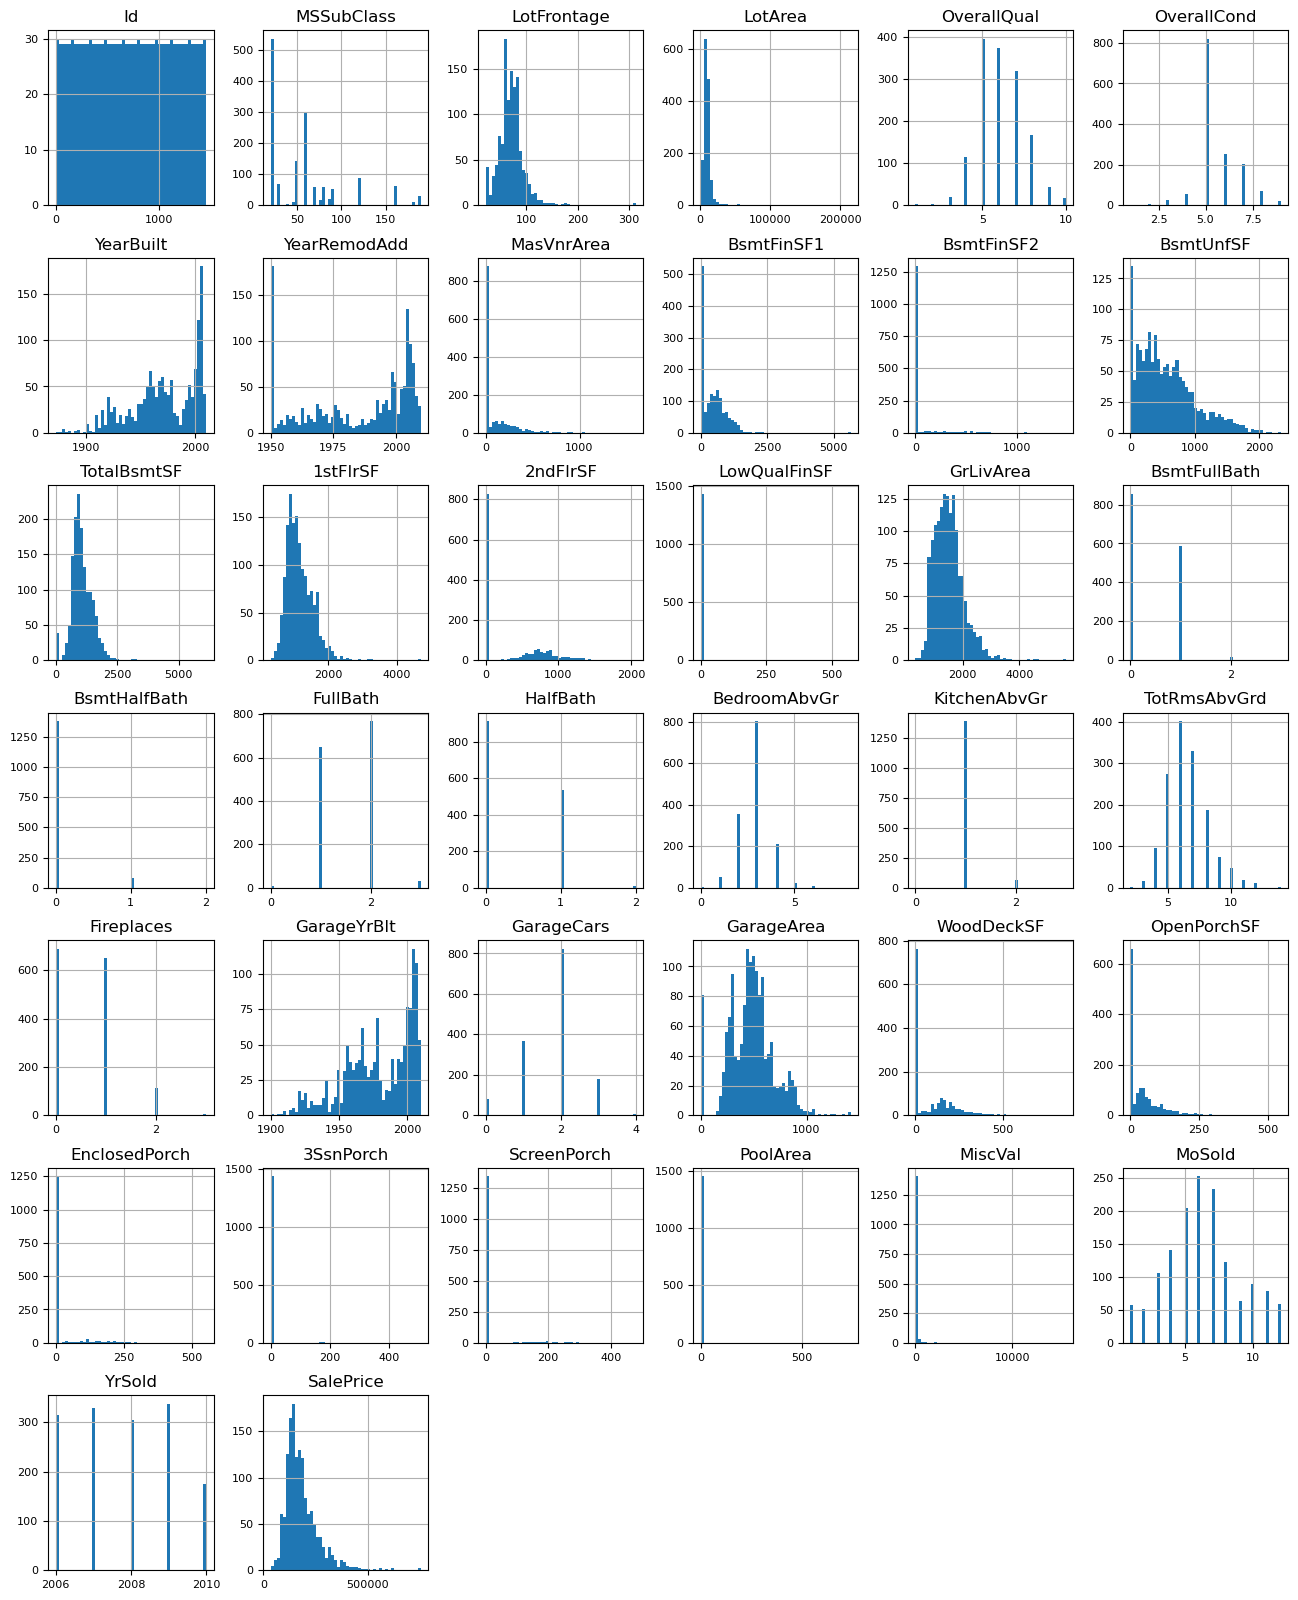

In [6]:
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


## Imputações

### Sobre a variável garagem e seus associados:
- GarageType: Categorico
- GarageYrBlt: Numerico
- GarageFinish: Categorico
- GarageQual: Categorico
- GarageCond: Categorico
<br>Seus valores nulos se referem à falta de garagem, portanto, para tratar de maneira adequada, iremos imputar zero para as variáveis numéricas e 'No Garage' para as variáveis categóricas

In [7]:

# Variáveis de garagem
garage_vars_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_vars_numeric = ['GarageYrBlt']

# Função para imputar valores ausentes
def impute_garage_variables(train, test):
    for var in garage_vars_categorical:
        if var in train.columns:
            train[var].fillna('None', inplace=True)
            test[var].fillna('None', inplace=True)

    for var in garage_vars_numeric:
        if var in train.columns:
            train[var].fillna(0, inplace=True)
            test[var].fillna(0, inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_garage_variables(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in garage_vars_categorical + garage_vars_numeric:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in garage_vars_categorical + garage_vars_numeric:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
GarageFinish: ['RFn' 'Unf' 'Fin' 'None']
GarageQual: ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
GarageCond: ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
GarageYrBlt: [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.    0. 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933.]

Teste - Valores únicos após imputação:
GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'None' 'Basment' '2Types' 'CarPort']
GarageFinish: ['Unf'

### Sobre a Variavel Bsmt
- BsmtQual - categorico (NA indica que nao há bsmt)
- BsmtCond - Categorico (NA indica que nao há bsmt)
- BsmtExposure - Categorico (NA indica que nao há bsmt)
- BsmtFinType1 e 2 - Categorico (NA indica que nao há bsmt)


In [8]:
basement_variables = ['BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2']
# Função para imputar valores ausentes
def impute_basement_variables(train, test):
    for var in basement_variables:
        if var in train.columns:
            train[var].fillna('None', inplace=True)
            test[var].fillna('None', inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_basement_variables(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in basement_variables:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in basement_variables:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
BsmtQual: ['Gd' 'TA' 'Ex' 'None' 'Fa']
BsmtCond: ['TA' 'Gd' 'None' 'Fa' 'Po']
BsmtExposure: ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
BsmtFinType2: ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']

Teste - Valores únicos após imputação:
BsmtQual: ['TA' 'Gd' 'Ex' 'Fa' 'None']
BsmtCond: ['TA' 'Po' 'Fa' 'Gd' 'None']
BsmtExposure: ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1: ['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' 'None']
BsmtFinType2: ['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' 'None']


### - PoolQC, FireplaceQC, Alley, Fence e MiscFeatures nulos significam sem essas características, iremos imputar com None para mantermos o padrão

In [9]:
leftover_variables = ['PoolQC', 'FireplaceQu', 'Alley', 'Fence', 'MiscFeature', 'MasVnrType']

def impute_leftover_variables(train, test):
    for var in leftover_variables:
        if var in train.columns:
            train[var].fillna('None', inplace=True)
            test[var].fillna('None', inplace=True)
        
    
# Aplicar a função aos DataFrames de treino e teste
impute_leftover_variables(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in leftover_variables:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in leftover_variables:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
PoolQC: ['None' 'Ex' 'Fa' 'Gd']
FireplaceQu: ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Alley: ['None' 'Grvl' 'Pave']
Fence: ['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
MiscFeature: ['None' 'Shed' 'Gar2' 'Othr' 'TenC']
MasVnrType: ['BrkFace' 'None' 'Stone' 'BrkCmn']

Teste - Valores únicos após imputação:
PoolQC: ['None' 'Ex' 'Gd']
FireplaceQu: ['None' 'TA' 'Gd' 'Po' 'Fa' 'Ex']
Alley: ['None' 'Pave' 'Grvl']
Fence: ['MnPrv' 'None' 'GdPrv' 'GdWo' 'MnWw']
MiscFeature: ['None' 'Gar2' 'Shed' 'Othr']
MasVnrType: ['None' 'BrkFace' 'Stone' 'BrkCmn']


### Sobre MasVnr:
- MasVnrType: NA indica ausencia de MasVnrType
- MasVnrArea: Todas as NA batem com NAs acima, chequei a mão

In [10]:
mas_vnr_categorical = 'MasVnrType'
mas_vnr_numeric = 'MasVnrArea'

# Função para imputar valores ausentes
def impute_mas_vnr(train, test):
    train[mas_vnr_categorical].fillna('None', inplace=True)
    test[mas_vnr_categorical].fillna('None', inplace=True)
    
    train[mas_vnr_numeric].fillna(0, inplace=True)
    test[mas_vnr_numeric].fillna(0, inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_mas_vnr(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
print(train[[mas_vnr_categorical, mas_vnr_numeric]].drop_duplicates())

print("\nTeste - Valores únicos após imputação:")
print(test[[mas_vnr_categorical, mas_vnr_numeric]].drop_duplicates())

Treino - Valores únicos após imputação:
     MasVnrType  MasVnrArea
0       BrkFace       196.0
1          None         0.0
2       BrkFace       162.0
4       BrkFace       350.0
6         Stone       186.0
...         ...         ...
1437      Stone       426.0
1439    BrkFace        96.0
1447    BrkFace       438.0
1451      Stone       194.0
1456      Stone       119.0

[401 rows x 2 columns]

Teste - Valores únicos após imputação:
     MasVnrType  MasVnrArea
0          None         0.0
1       BrkFace       108.0
3       BrkFace        20.0
11      BrkFace       504.0
12      BrkFace       492.0
...         ...         ...
1399    BrkFace       355.0
1425    BrkFace       405.0
1430    BrkFace       327.0
1439    BrkFace       257.0
1443    BrkFace       382.0

[370 rows x 2 columns]


### Sobre LotFrontage: como é possível ver nos gráficos, sua distribuição não é nem perto da normal, por isso, iremos imputar com a mediana

In [11]:
frontage = ['LotFrontage']

def impute_frontage(train, test):
    for var in frontage:
        if var in train.columns:
            median = train[var].median()
            train[var].fillna(median, inplace=True)
            test[var].fillna(median, inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_frontage(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in frontage:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in frontage:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
LotFrontage: [ 65.  80.  68.  60.  84.  85.  75.  69.  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  21.  32.  78. 121. 122.  40. 105.
  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92. 134.
  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.  93.
  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.  36.
  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39. 144.
 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]

Teste - Valores únicos após imputação:
LotFrontage: [ 80.  81.  74.  78.  43.  75.  69.  63.  85.  70.  26.  21.  24. 102.
  94.  90.  79. 110. 105.  41. 100.  67.  60.  73.  92.  84.  39.  88.
  25.  30.  57.  68.  98. 120.  87. 119.  65.  56.  50.  53.  52.  51.
  72.  86. 124.  44.  83.  64.  82.  38.  89.  35.  58.  66.  93.  31.
  76.  28.  61.  95. 129.  59.  77.  96.  47.  34. 

### Checando os datasets para ver se foram imputados corretamente

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Aparentemente, algumas entradas ficaram faltando, como MSZoning, Utilities, Exterior1st, Exterior2nd, BsmtFinSF1,BsmtFinSF2,BsmtUnfSF  ,TotalBsmtSF, BsmtFullBath, BsmtHalfBath, KitchenQual, Functional, SaleType, GarageCars, GarageArea, BsmtUnfSF

In [14]:
import pandas as pd

# Assuming you have a training DataFrame named `train`
# Calculate the mode for each column in the training dataset
Mode = test.mode().iloc[0]

# Reset the index of the Mode DataFrame
Mode.reset_index(drop=True, inplace=True)

# Define the list of leftover test variables (replace with your actual variables)
leftover_test_variables = ['MSZoning', 'Utilities', 'Exterior2nd', 'Exterior1st', 'BsmtFinSF1', 
                           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                           'KitchenQual', 'Functional', 'SaleType', 'GarageCars', 'GarageArea', 'BsmtUnfSF']

# Function to impute missing values in the test dataset
def impute_leftover_test_variables(test):
    for var in leftover_test_variables:
        if var in test.columns:
            if var in Mode.index:
                test[var].fillna(Mode[var], inplace=True)
            else:
                # If the variable is not in Mode, fill with the most common value in the column
                mode_val = test[var].mode()[0]
                test[var].fillna(mode_val, inplace=True)

# Assuming you have a test DataFrame named `test`
# Apply the function to the test DataFrame
impute_leftover_test_variables(test)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [15]:
train_num = train.select_dtypes(include=['float64', 'int64'])
train_cat = train.select_dtypes(exclude=['float64', 'int64'])
test_num = test.select_dtypes(include=['float64', 'int64'])
test_cat = test.select_dtypes(exclude=['float64', 'int64'])

In [16]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          1460 non-null   object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1460 non-null   object
 18  ExterQual      1460 non-null

In [17]:
test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1459 non-null   object
 1   Street         1459 non-null   object
 2   Alley          1459 non-null   object
 3   LotShape       1459 non-null   object
 4   LandContour    1459 non-null   object
 5   Utilities      1459 non-null   object
 6   LotConfig      1459 non-null   object
 7   LandSlope      1459 non-null   object
 8   Neighborhood   1459 non-null   object
 9   Condition1     1459 non-null   object
 10  Condition2     1459 non-null   object
 11  BldgType       1459 non-null   object
 12  HouseStyle     1459 non-null   object
 13  RoofStyle      1459 non-null   object
 14  RoofMatl       1459 non-null   object
 15  Exterior1st    1459 non-null   object
 16  Exterior2nd    1459 non-null   object
 17  MasVnrType     1459 non-null   object
 18  ExterQual      1459 non-null

## Testes de hipótese: Teste Chi-Quadrado


In [18]:
significance_level = 0.05
target_variable = 'SalePrice'
# Function to perform Chi-Squared test
def chi_squared_test(train, target='SalePrice', significance_level=0.05):
    results = {}
    train_cat = train.select_dtypes(include=['object'])  # Selecting only categorical columns
    for column in train_cat:
        contingency_table = pd.crosstab(train_cat[column], train[target])
        chi2_stat, p, dof, ex = chi2_contingency(contingency_table)
        critical_value = chi2.ppf(1 - significance_level, dof)
        results[column] = {'chi2': chi2_stat, 'p_value': p, 'dof': dof, 'critical_value': critical_value}
    return results

# Perform the Chi-Squared tests on the training set
chi2_results = chi_squared_test(train, target_variable)

# Display results
for column, result in chi2_results.items():
    print(f"Variable: {column}")
    print(f"  Chi2: {result['chi2']}")
    print(f"  p-value: {result['p_value']}")
    print(f"  Degrees of Freedom: {result['dof']}")
    print(f"  Critical Value: {result['critical_value']}")
    if result['p_value'] < significance_level and result['chi2'] > result['critical_value']:
        print(f"  {column} is correlated with {target_variable}")
    elif result['p_value'] >= significance_level and result['chi2'] <= result['critical_value']:
        print(f"  {column} is NOT correlated with {target_variable}")
    else:
        print('  Results are conflicting')
    print("\n")

Variable: MSZoning
  Chi2: 3147.8911158183737
  p-value: 4.3483250606822396e-11
  Degrees of Freedom: 2648
  Critical Value: 2768.8281535489073
  MSZoning is correlated with SalePrice


Variable: Street
  Chi2: 888.3129945096931
  p-value: 8.338870380464053e-09
  Degrees of Freedom: 662
  Critical Value: 722.9662553606306
  Street is correlated with SalePrice


Variable: Alley
  Chi2: 1233.0758732766717
  p-value: 0.9637567934663973
  Degrees of Freedom: 1324
  Critical Value: 1409.7637498147142
  Alley is NOT correlated with SalePrice


Variable: LotShape
  Chi2: 2446.2353573800365
  p-value: 4.724729155980402e-12
  Degrees of Freedom: 1986
  Critical Value: 2090.7894487834265
  LotShape is correlated with SalePrice


Variable: LandContour
  Chi2: 2072.335508433759
  p-value: 0.08674645041917711
  Degrees of Freedom: 1986
  Critical Value: 2090.7894487834265
  LandContour is NOT correlated with SalePrice


Variable: Utilities
  Chi2: 242.49942883253368
  p-value: 1.0
  Degrees of Free

### Seleção de features categóricas

In [19]:
corr_train_cat = pd.DataFrame()

# Iterate through the correlated variables and concatenate them into the new DataFrame
for column, result in chi2_results.items():
    if result['p_value'] < significance_level and result['chi2'] > result['critical_value']:
        correlated_var = train[column]
        corr_train_cat[column] = correlated_var

# Display the new DataFrame
corr_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LotConfig      1460 non-null   object
 4   Neighborhood   1460 non-null   object
 5   MasVnrType     1460 non-null   object
 6   ExterQual      1460 non-null   object
 7   ExterCond      1460 non-null   object
 8   Foundation     1460 non-null   object
 9   BsmtQual       1460 non-null   object
 10  BsmtCond       1460 non-null   object
 11  BsmtExposure   1460 non-null   object
 12  Heating        1460 non-null   object
 13  CentralAir     1460 non-null   object
 14  KitchenQual    1460 non-null   object
 15  FireplaceQu    1460 non-null   object
 16  GarageFinish   1460 non-null   object
 17  SaleType       1460 non-null   object
 18  SaleCondition  1460 non-null

### Categorical Test variables

In [20]:
# Step 1: Select categorical features from the train and test set
train_cat = train.select_dtypes(include=['object'])
test_cat = test.select_dtypes(include=['object'])

# Step 2: Ensure corr_test_cat has the same columns as corr_train_cat
# Step 2: Ensure corr_test_cat has the same columns and rows as corr_train_cat
corr_test_cat = test_cat.reindex(columns=corr_train_cat.columns)

# Optional: Verify column consistency
corr_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1459 non-null   object
 1   Street         1459 non-null   object
 2   LotShape       1459 non-null   object
 3   LotConfig      1459 non-null   object
 4   Neighborhood   1459 non-null   object
 5   MasVnrType     1459 non-null   object
 6   ExterQual      1459 non-null   object
 7   ExterCond      1459 non-null   object
 8   Foundation     1459 non-null   object
 9   BsmtQual       1459 non-null   object
 10  BsmtCond       1459 non-null   object
 11  BsmtExposure   1459 non-null   object
 12  Heating        1459 non-null   object
 13  CentralAir     1459 non-null   object
 14  KitchenQual    1459 non-null   object
 15  FireplaceQu    1459 non-null   object
 16  GarageFinish   1459 non-null   object
 17  SaleType       1459 non-null   object
 18  SaleCondition  1459 non-null

## Label Encoding

In [21]:
# Initialize a dictionary to hold the label encoders
label_encoders = {}

# Apply label encoding to training data from corr_train_cat
new_train_cat = pd.DataFrame()
for col in corr_train_cat.columns:
    # Access data from corr_train_cat using column name
    data_to_encode = corr_train_cat[col]
    le = LabelEncoder()
    encoded_values = le.fit_transform(data_to_encode)
    new_train_cat[col] = encoded_values
    label_encoders[col] = le

# Apply the same label encoders to the test data from corr_test_cat
new_test_cat = pd.DataFrame()
for col in corr_test_cat.columns:
    if col in label_encoders:
        # Access data from corr_test_cat using column name
        data_to_encode = corr_test_cat[col]
        # Use the fitted encoder from label_encoders dictionary
        le = label_encoders[col]
        encoded_values = le.transform(data_to_encode)
        new_test_cat[col] = encoded_values
    else:
        raise ValueError(f"Column '{col}' in corr_test_cat does not have a corresponding encoder in corr_train_cat")

# Check if any columns are in corr_train_cat but not in corr_test_cat and add them as NaNs
for col in new_train_cat.columns:
    if col not in new_test_cat.columns:
        new_test_cat[col] = pd.NA

# Ensure the columns are in the same order
new_test_cat = new_test_cat[new_train_cat.columns]



In [22]:
new_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSZoning       1460 non-null   int64
 1   Street         1460 non-null   int64
 2   LotShape       1460 non-null   int64
 3   LotConfig      1460 non-null   int64
 4   Neighborhood   1460 non-null   int64
 5   MasVnrType     1460 non-null   int64
 6   ExterQual      1460 non-null   int64
 7   ExterCond      1460 non-null   int64
 8   Foundation     1460 non-null   int64
 9   BsmtQual       1460 non-null   int64
 10  BsmtCond       1460 non-null   int64
 11  BsmtExposure   1460 non-null   int64
 12  Heating        1460 non-null   int64
 13  CentralAir     1460 non-null   int64
 14  KitchenQual    1460 non-null   int64
 15  FireplaceQu    1460 non-null   int64
 16  GarageFinish   1460 non-null   int64
 17  SaleType       1460 non-null   int64
 18  SaleCondition  1460 non-null   int64
dtypes: int

In [23]:
new_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSZoning       1459 non-null   int64
 1   Street         1459 non-null   int64
 2   LotShape       1459 non-null   int64
 3   LotConfig      1459 non-null   int64
 4   Neighborhood   1459 non-null   int64
 5   MasVnrType     1459 non-null   int64
 6   ExterQual      1459 non-null   int64
 7   ExterCond      1459 non-null   int64
 8   Foundation     1459 non-null   int64
 9   BsmtQual       1459 non-null   int64
 10  BsmtCond       1459 non-null   int64
 11  BsmtExposure   1459 non-null   int64
 12  Heating        1459 non-null   int64
 13  CentralAir     1459 non-null   int64
 14  KitchenQual    1459 non-null   int64
 15  FireplaceQu    1459 non-null   int64
 16  GarageFinish   1459 non-null   int64
 17  SaleType       1459 non-null   int64
 18  SaleCondition  1459 non-null   int64
dtypes: int

## Distribuição de variáveis numéricas


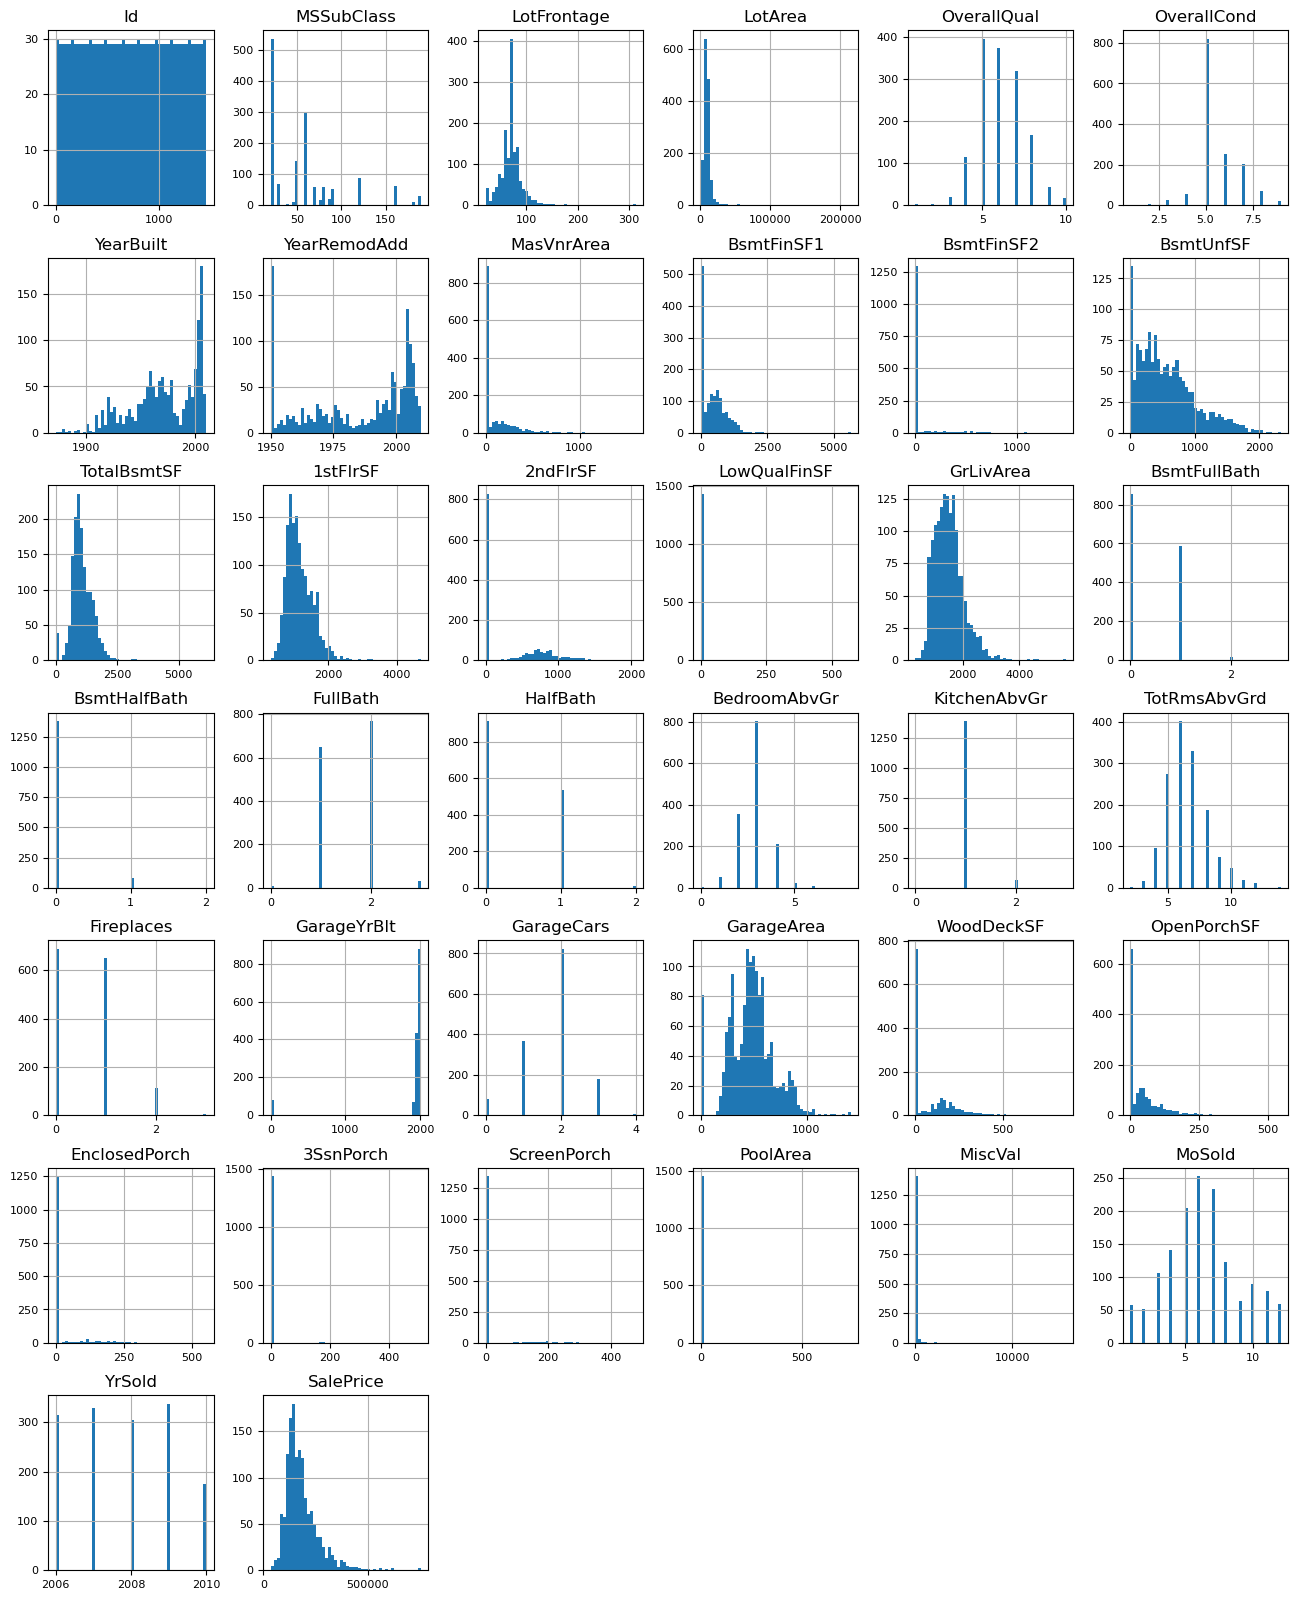

In [24]:
train_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


Claramente, nenhum dos dados numéricos segue uma distribuição normal, para checar a correlação, portanto, não podemos usar ANOVA, para resolvermos o problema, usaremos uma tecnica conhecida como Bootstrapping (bagging)


### Bootstrapping

In [25]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1460 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

In [26]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def bootstrap_feature_selection(train_data, target_column, num_iterations=200, num_features_to_select=25):
    all_selected_features = []

    for _ in range(num_iterations):
        # Create a bootstrap sample from the training data
        bootstrap_sample = resample(train_data, replace=True)
        
        # Separate features and target
        X_bootstrap = bootstrap_sample.drop(columns=[target_column])
        y_bootstrap = bootstrap_sample[target_column]
        
        # Perform feature selection
        model = LinearRegression()
        selector = RFE(model, n_features_to_select=num_features_to_select, step=1)
        selector = selector.fit(X_bootstrap, y_bootstrap)
        
        # Get the selected feature indices
        selected_features = X_bootstrap.columns[selector.support_]
        all_selected_features.extend(selected_features)
    
    # Determine the most frequently selected features
    feature_counts = pd.Series(all_selected_features).value_counts()
    best_features = feature_counts.nlargest(num_features_to_select).index.tolist()
    
    return best_features

# Assuming train_num and test_num are your training and testing datasets with numerical features
# Load your train and test datasets
# train_num = pd.read_csv('path_to_train_num.csv')
# test_num = pd.read_csv('path_to_test_num.csv')

# Define the target column
target_column = 'SalePrice'

# Perform bootstrap feature selection
best_features = bootstrap_feature_selection(train_num, target_column)

# Create new datasets with the selected features
new_train_num = train_num[best_features + [target_column]]
new_test_num = test_num[best_features]

# Display the new datasets
print("Selected Best Features:", best_features)


Selected Best Features: ['OverallQual', 'TotRmsAbvGrd', 'KitchenAbvGr', 'BedroomAbvGr', 'MSSubClass', 'BsmtFullBath', 'OverallCond', 'YearBuilt', 'GarageCars', 'FullBath', 'HalfBath', 'Fireplaces', 'BsmtHalfBath', 'GrLivArea', 'YrSold', 'MoSold', 'YearRemodAdd', '1stFlrSF', 'LotFrontage', '2ndFlrSF', 'LowQualFinSF', 'PoolArea', 'MasVnrArea', 'ScreenPorch', 'TotalBsmtSF']


### Seleção de features numéricas

In [27]:
new_train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   TotRmsAbvGrd  1460 non-null   int64  
 2   KitchenAbvGr  1460 non-null   int64  
 3   BedroomAbvGr  1460 non-null   int64  
 4   MSSubClass    1460 non-null   int64  
 5   BsmtFullBath  1460 non-null   int64  
 6   OverallCond   1460 non-null   int64  
 7   YearBuilt     1460 non-null   int64  
 8   GarageCars    1460 non-null   int64  
 9   FullBath      1460 non-null   int64  
 10  HalfBath      1460 non-null   int64  
 11  Fireplaces    1460 non-null   int64  
 12  BsmtHalfBath  1460 non-null   int64  
 13  GrLivArea     1460 non-null   int64  
 14  YrSold        1460 non-null   int64  
 15  MoSold        1460 non-null   int64  
 16  YearRemodAdd  1460 non-null   int64  
 17  1stFlrSF      1460 non-null   int64  
 18  LotFrontage   1460 non-null 

In [28]:
new_test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   TotRmsAbvGrd  1459 non-null   int64  
 2   KitchenAbvGr  1459 non-null   int64  
 3   BedroomAbvGr  1459 non-null   int64  
 4   MSSubClass    1459 non-null   int64  
 5   BsmtFullBath  1459 non-null   float64
 6   OverallCond   1459 non-null   int64  
 7   YearBuilt     1459 non-null   int64  
 8   GarageCars    1459 non-null   float64
 9   FullBath      1459 non-null   int64  
 10  HalfBath      1459 non-null   int64  
 11  Fireplaces    1459 non-null   int64  
 12  BsmtHalfBath  1459 non-null   float64
 13  GrLivArea     1459 non-null   int64  
 14  YrSold        1459 non-null   int64  
 15  MoSold        1459 non-null   int64  
 16  YearRemodAdd  1459 non-null   int64  
 17  1stFlrSF      1459 non-null   int64  
 18  LotFrontage   1459 non-null 

## Concatenando as duas novas listas

In [29]:
train_final = pd.concat([new_train_cat, new_train_num], axis=1)

# Display the combined dataframe
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   int64  
 1   Street         1460 non-null   int64  
 2   LotShape       1460 non-null   int64  
 3   LotConfig      1460 non-null   int64  
 4   Neighborhood   1460 non-null   int64  
 5   MasVnrType     1460 non-null   int64  
 6   ExterQual      1460 non-null   int64  
 7   ExterCond      1460 non-null   int64  
 8   Foundation     1460 non-null   int64  
 9   BsmtQual       1460 non-null   int64  
 10  BsmtCond       1460 non-null   int64  
 11  BsmtExposure   1460 non-null   int64  
 12  Heating        1460 non-null   int64  
 13  CentralAir     1460 non-null   int64  
 14  KitchenQual    1460 non-null   int64  
 15  FireplaceQu    1460 non-null   int64  
 16  GarageFinish   1460 non-null   int64  
 17  SaleType       1460 non-null   int64  
 18  SaleCond

In [30]:
test_final = pd.concat([new_test_cat, new_test_num], axis=1)

# Display the combined dataframe
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1459 non-null   int64  
 1   Street         1459 non-null   int64  
 2   LotShape       1459 non-null   int64  
 3   LotConfig      1459 non-null   int64  
 4   Neighborhood   1459 non-null   int64  
 5   MasVnrType     1459 non-null   int64  
 6   ExterQual      1459 non-null   int64  
 7   ExterCond      1459 non-null   int64  
 8   Foundation     1459 non-null   int64  
 9   BsmtQual       1459 non-null   int64  
 10  BsmtCond       1459 non-null   int64  
 11  BsmtExposure   1459 non-null   int64  
 12  Heating        1459 non-null   int64  
 13  CentralAir     1459 non-null   int64  
 14  KitchenQual    1459 non-null   int64  
 15  FireplaceQu    1459 non-null   int64  
 16  GarageFinish   1459 non-null   int64  
 17  SaleType       1459 non-null   int64  
 18  SaleCond

## Modelagem

In [31]:
from tensorflow_decision_forests.keras import GradientBoostedTreesModel

# Convert Pandas DataFrames to TensorFlow datasets with regression task
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_final, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_final, task=tfdf.keras.Task.REGRESSION)

# Create a Gradient Boosted Trees model for regression task
gbt_model = GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)

# Compile the model with mean squared error (mse) as the evaluation metric
gbt_model.compile(metrics=["mse"])

# Fit the model with training data (train_dataset)
gbt_model.fit(train_dataset)

# Evaluate the model with testing data (test_dataset)
mse = gbt_model.evaluate(train_dataset)

# Print the Mean Squared Error (MSE)
print("Mean Squared Error (MSE):", mse)

Use /tmp/tmp6_93hz1l as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.134042. Found 1460 examples.
Training model...
Model trained in 0:00:01.318297
Compiling model...


[INFO 2024-05-26T00:01:26.62640015+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6_93hz1l/model/ with prefix 346539799bc6491b
[INFO 2024-05-26T00:01:26.639119796+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-05-26T00:01:26.639328816+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
2/2 [==============================] - 1s 16ms/step - loss: 0.0000e+00 - mse: 222133008.0000
Mean Squared Error (MSE): [0.0, 222133008.0]


In [32]:
from catboost import CatBoostRegressor
# Define features and target variables
features = train_final.drop('SalePrice', axis=1).columns
target = 'SalePrice'

# Create CatBoostRegressor model
model = CatBoostRegressor()

# Train the model on train_final
model.fit(train_final[features], train_final[target])

# Predict SalePrice for test_final data
predictions = model.predict(test_final[features])


Learning rate set to 0.043466
0:	learn: 77271.8049994	total: 59.1ms	remaining: 59.1s
1:	learn: 75096.8542511	total: 61.3ms	remaining: 30.6s
2:	learn: 72902.6366331	total: 63.3ms	remaining: 21s
3:	learn: 70964.7947399	total: 65.2ms	remaining: 16.2s
4:	learn: 69234.5218019	total: 67.2ms	remaining: 13.4s
5:	learn: 67364.7728061	total: 69.2ms	remaining: 11.5s
6:	learn: 65631.1548240	total: 71ms	remaining: 10.1s
7:	learn: 63921.0420947	total: 72.9ms	remaining: 9.04s
8:	learn: 62347.1038870	total: 74.7ms	remaining: 8.23s
9:	learn: 60769.6480765	total: 76.6ms	remaining: 7.59s
10:	learn: 59322.1693392	total: 78.6ms	remaining: 7.06s
11:	learn: 57857.8217917	total: 80.5ms	remaining: 6.62s
12:	learn: 56463.2777548	total: 82.3ms	remaining: 6.25s
13:	learn: 55211.5045240	total: 84.1ms	remaining: 5.92s
14:	learn: 54005.7978661	total: 85.9ms	remaining: 5.64s
15:	learn: 52765.0738379	total: 87.9ms	remaining: 5.41s
16:	learn: 51718.9014390	total: 89.8ms	remaining: 5.19s
17:	learn: 50702.0811620	total: 

# Submission
Finally predict on the competition test data using the model.

In [33]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test = pd.read_csv(test_file_path)
ids = test.pop('Id')

preds = model.predict(test_final)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

,Id,SalePrice
0,1461,119299.257555
1,1462,148229.000739
2,1463,169667.415690
3,1464,186086.610331
4,1465,181309.992571


In [34]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = model.predict(test_final)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,Id,SalePrice
0,1461,119299.257555
1,1462,148229.000739
2,1463,169667.415690
3,1464,186086.610331
4,1465,181309.992571
